In this post, I will use Random Forest method to predict default rate.   

## Data
To answer the question, I will analyze loan data for 5000 banking system customers in a Middle Eastern country. 

In [95]:
import pandas as pd
df = pd.read_csv("C:\\Users\\rtava\\OneDrive\\Documents\\Git\\MLProject\\loans_clean.csv")

In [96]:
print("This dataset has", df.shape[0], "records with", df.shape[1], "atributes")
print("About", df.label.mean().round(2) , "of lables was defaulted with label 1") 

This dataset has 5578 records with 16 atributes
About 0.38 of lables was defaulted with label 1


## Varibales

The following table provide a description for variables in the data set. 

|Variable name |Description| 
|:-----|:-----|
|age |Age of borrower|
|install|Number of requested loan's installment|
|amount|Number of requested loan|
|delayed| total delyaed that the borrower had|
|neg2y|Number of negative status in recent two years |
|neg2yb|Number of negative status before recent two years|
|pd_6m|Number of past due payment in recent 6 months|
|pd_618|Number of past due payment in recent 6-18 months|
|pd_18m|Number of past due payment before recent 18 months|
|ud_12m|Number of unpaid payment in recent 12 months|
|ud_12mm|Number of unpaid payment before recent 12 months|
|nloans|Number of terminated loan the person have had|
|loanAge| The lodest loan age|
|remain| Outstanding debt to total debt (ratio)|
|wneg_2y|Worst negative status in recent two years|
|label|is =1 if the costumer paid at least one installment with more than 90 days delay|



## Descriptive Statistics

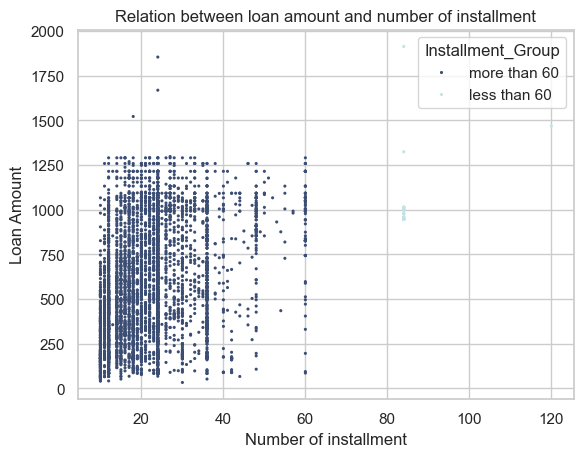

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

df.loc[df['install']>61, 'Installment_Group']="less than 60"
df.Installment_Group.fillna("more than 60", inplace=True)


plot = sns.scatterplot(x="install", y="amount",
                s=5, palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0, hue="Installment_Group",
                data=df);
plot.set_xlabel("Number of installment")
plot.set_ylabel("Loan Amount")
plot.set_title("Relation between loan amount and number of installment")

plt.show();


### Dealing with outliers
The following lines remove outliers using interquartile range method:

In [98]:
import warnings
warnings.filterwarnings('ignore')

df.drop(columns='Installment_Group', inplace=True)
df_new = df

for c in df_new.columns:
    q1 = df_new[c].quantile(0.05)
    q3 = df_new[c].quantile(0.95)
    iqr = q3-q1
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr

    for i in range(len(df)):
        if df_new.loc[i, c] < lower_fence or df_new.loc[i, c] > upper_fence:  # if outlier
            df_new.loc[i, "out_" + c] = 1
        else:
            df_new.loc[i, "out_" + c] = 0

out_col = [col for col in df_new.columns if 'out_' in col]
df_new['out'] = df_new[out_col].sum(axis=1)

df_new = df_new.loc[df_new.out==0]
df_new.drop([col for col in df_new.columns if 'out_' in col], axis=1, inplace=True)
df_new.drop(columns=['out'], inplace=True)


I change the categorical dummies to usual dummies:

In [99]:
df_prep = pd.get_dummies(df_new, columns=['wneg_2y'])

for column in ['wneg_2y_0.0', 
          'wneg_2y_1.0', 
          'wneg_2y_2.0',
          'wneg_2y_3.0']:
        df_prep[column] = df_prep[column].replace({True: 1, False: 0})

### Correlation between variabels: 

<Axes: >

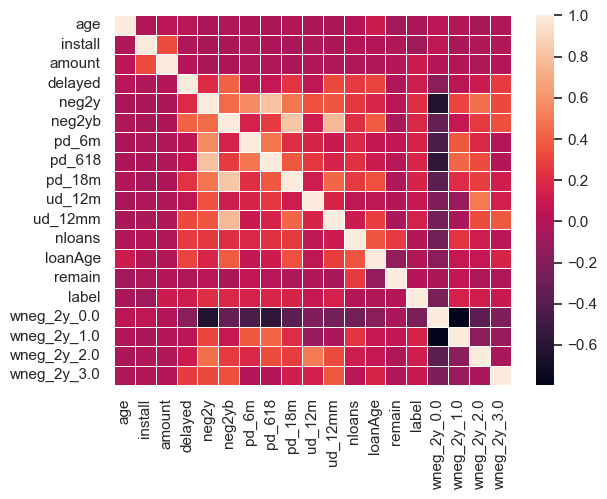

In [100]:
corr = df_prep.corr(method = 'pearson')
corr
sns.heatmap(corr,annot=False,fmt=".1f", linewidth=.5)

Based on the heat map correlation, I will remove "wneg" variables. 

In [101]:
x_col = ['age', 'install', 'amount', 'delayed', 'neg2y', 'neg2yb', 'pd_6m',
       'pd_618', 'pd_18m', 'ud_12m', 'ud_12mm', 'nloans', 'loanAge',
       'remain']

<h2 id="model">About the Model</h2>

In [102]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_prep, test_size=0.2, random_state = 1234)

X_train, y_train = df_train[x_col], df_train['label']
X_test, y_test = df_test[x_col], df_test['label']

print("Train Sample Size:", X_train.shape[0],
      "\nTest Sample Size:", X_test.shape[0])

Train Sample Size: 4252 
Test Sample Size: 1064


In [120]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 

threshold = 0.5

RF_model = RandomForestClassifier(random_state=1234, max_depth = 20, n_estimators=100, class_weight='balanced')
RF_model.fit(X_train,y_train)
y_prob_RF = RF_model.predict_proba(X_test)
y_pred_RF = (y_prob_RF[:,1] >= threshold).astype('int')


## Model Evaluation

In [121]:
Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
F1_RF = metrics.f1_score(y_test, y_pred_RF)
AUC = metrics.roc_auc_score(y_test, y_pred_RF)
clas_report = metrics.classification_report(y_test, y_pred_RF)

print("RF Accuracy: %0.2f" % (Accuracy_RF), "\nF1 Score: %0.2f" % (F1_RF), "\nAUC_ROC: %0.2f" % (AUC))

RF Accuracy: 0.69 
F1 Score: 0.49 
AUC_ROC: 0.63


### Confusion Matrix

<Axes: >

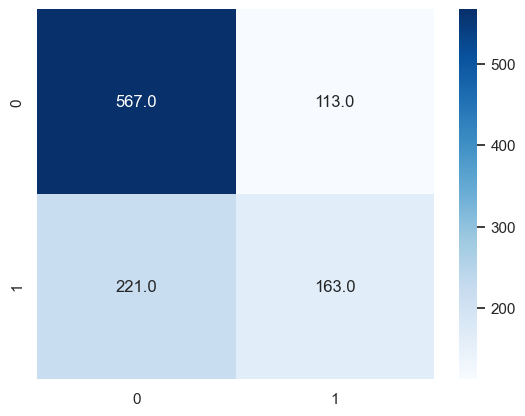

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix = confusion_matrix(y_test, y_pred_RF)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='0.1f')

### Optimal Threshold

In [106]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

Fscore = []
thrsh = []
for i in range(10,65,1):
    threshold = i/100
    thrsh.append(threshold)

    RF_model = RandomForestClassifier(random_state=1234, max_depth = 20, n_estimators=100, class_weight='balanced')
    RF_model.fit(X_train,y_train)
    y_prob_RF = RF_model.predict_proba(X_test)
    y_pred_RF = (y_prob_RF[:,1] >= threshold).astype('int')
    Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
    Fscore.append(metrics.f1_score(y_test, y_pred_RF))

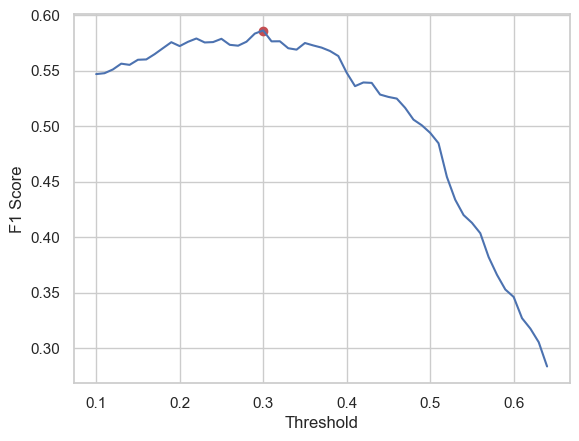

In [107]:
plot = sns.lineplot(x=thrsh, y=Fscore)
plt.scatter(x=0.3, y=0.586, color='r')
plot.set_xlabel("Threshold")
plot.set_ylabel("F1 Score");

We can see that the optimal threshold is 0.3, then we have:

RF Accuracy: 0.61 
F1 Score: 0.59 
AUC_ROC: 0.64


<Axes: >

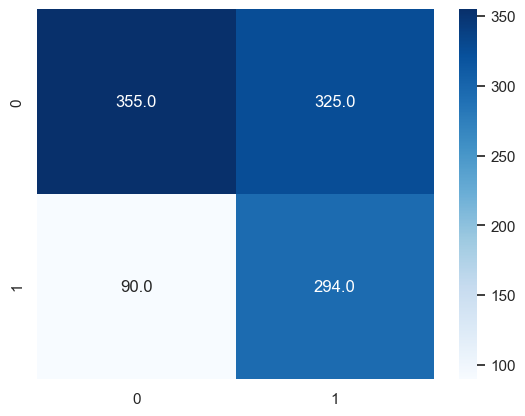

In [118]:
threshold = 0.3
y_pred_RF = (y_prob_RF[:,1] >= threshold).astype('int')

Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
F1_RF = metrics.f1_score(y_test, y_pred_RF)
AUC = metrics.roc_auc_score(y_test, y_pred_RF)
clas_report = metrics.classification_report(y_test, y_pred_RF)

print("RF Accuracy: %0.2f" % (Accuracy_RF), "\nF1 Score: %0.2f" % (F1_RF), "\nAUC_ROC: %0.2f" % (AUC))
cf_matrix = confusion_matrix(y_test, y_pred_RF)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='0.1f');